$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{\top}}{\sqrt{a_{k}}}\right) V
$$

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

2022-05-09 19:11:37.683421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 19:11:37.683441: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
dataset, info = tfds.load(
    "imdb_reviews/plain_text",
    split=["train[:80%]", "train[80%:]", "test"],
    as_supervised=True,
    with_info = True
)

dataset_train_original = dataset[0]
dataset_validate_original = dataset[1]
dataset_test_original = dataset[2]

In [ ]:
dataset_train_original

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [4]:
dataset_train_original.map(lambda text, label: text)

<MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [5]:
tdataset = dataset_train_original.batch(3)

In [6]:
for x, y in tdataset.take(1):
  print(x.numpy())
  print("")
  print(y)

[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development w

2022-05-09 19:12:03.972968: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
tdataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [7]:
vocabulary_size = 10000
sequence_length=128

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=sequence_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int"
)
encoder.adapt(dataset_train_original.map(lambda text, label: text).batch(512))

In [8]:
dataset_train = dataset_train_original.map(lambda text, label: (encoder(text), label))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(25000)
dataset_train = dataset_train.batch(128)

dataset_validate = dataset_validate_original.map(lambda text, label: (encoder(text), label))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(128)

In [9]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [10]:
model = models.Sequential()

model.add(layers.Embedding(vocabulary_size, 256, input_length=sequence_length))
for _ in range(4):
  model.add(TransformerEncoder(embed_dim=256, dense_dim=32, num_heads=2))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 256)          2560000   
                                                                 
 transformer_encoder (Transf  (None, 128, 256)         543776    
 ormerEncoder)                                                   
                                                                 
 transformer_encoder_1 (Tran  (None, 128, 256)         543776    
 sformerEncoder)                                                 
                                                                 
 transformer_encoder_2 (Tran  (None, 128, 256)         543776    
 sformerEncoder)                                                 
                                                                 
 transformer_encoder_3 (Tran  (None, 128, 256)         543776    
 sformerEncoder)                                        

In [11]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs=10,
    validation_data=dataset_validate
)


Epoch 1/10
157/157 [==============================] - 512s 3s/step - loss: 0.4700 - accuracy: 0.7893 - val_loss: 0.4051 - val_accuracy: 0.8202
Epoch 2/10
157/157 [==============================] - 486s 3s/step - loss: 0.2583 - accuracy: 0.8943 - val_loss: 0.3838 - val_accuracy: 0.8382
Epoch 3/10
157/157 [==============================] - 460s 3s/step - loss: 0.1650 - accuracy: 0.9407 - val_loss: 0.4355 - val_accuracy: 0.8242
Epoch 4/10
157/157 [==============================] - 454s 3s/step - loss: 0.0955 - accuracy: 0.9728 - val_loss: 0.4284 - val_accuracy: 0.8320
Epoch 5/10
157/157 [==============================] - 455s 3s/step - loss: 0.0454 - accuracy: 0.9930 - val_loss: 0.4637 - val_accuracy: 0.8352
Epoch 6/10
157/157 [==============================] - 454s 3s/step - loss: 0.0163 - accuracy: 0.9992 - val_loss: 0.5022 - val_accuracy: 0.8370
Epoch 7/10
157/157 [==============================] - 454s 3s/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.5675 - val_accuracy: 0.8386

In [ ]:
def render_history(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()

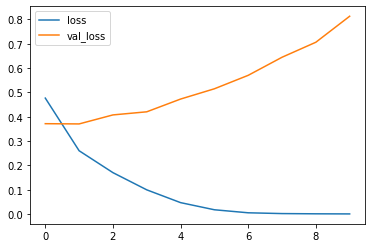

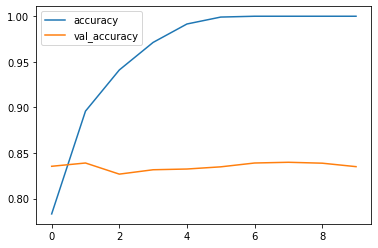

In [ ]:
render_history(history)